<a href="https://colab.research.google.com/github/Sreyteavsry/App/blob/master/Final_Version__2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing the libraries**





In [51]:
!pip install colabcode
!pip install fastapi


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
from colabcode import ColabCode
from fastapi import FastAPI
app = FastAPI()
@app.get("/")
async def read_root():
  return {"message": "Compound Identification"}
cc = ColabCode(port=12000, code=False)

In [53]:
# cc.run_app(app=app)

In [54]:
import pickle

In [55]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np
import time
import math

**Checking for available GPU**

In [56]:
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
  print("Training on GPU")
else:
  print("No GPU available")

Training on GPU


#Dataset



##Loading files

In [57]:
def compound_tag(str): #remove the combinded tags (compound words)
    ls = ['n-[', 'o-[','v-[','v[','o[', 'n[' ,'a-[', 'a[','1[','.[','+[', '_n-','_n', '_v', '_o-','_o','_a-', '_a','_1-','_.-','_1', '_.']
    #ls = ['o[', 'n[', 'n-[', 'o-[','v-[','v[','a-[', 'a[','1[','.[','+[',']n-',']n',']o-',']v-',']v',']o',']a-',']a',']1',']o-','].', ']+','_n', '_n-', '_v', '_o','_a','_1', '_.']
    cm = [']n-',']n',']o-',']v-',']v',']o',']a-',']a',']1',']o-','].', ']+']
    for i in ls:
      str = str.replace(i,'')
    for ii in cm:
      str = str.replace(']', '_c')
    return str

In [58]:
def cls(str): #remove the combinded tags (compound words)
    ls = ['o[', 'n[', 'n-[', 'o-[','v-[','v[','a-[', 'a[','1[','.[','+[',']n-',']n',']o-',']v-',']v',']o',']a-',']a',']1',']o-','].', ']+']
    for i in ls:
      str = str.replace(i,'')
    return str

In [59]:
from google.colab import drive
drive.mount('/content/drive')
f_tok = open('/content/drive/MyDrive/Dataset/Khmer NLP/data_km.km-tok.txt', 'r', encoding ='utf-8')

f_tag = open('/content/drive/MyDrive/Dataset/Khmer NLP/data_km.km-tag.txt', 'r', encoding ='utf-8')
tok = [x.split() for x in f_tok] #split each sentence by space into word list
postag = [x.split() for x in f_tag] #split each sentence by space into tag list

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Combining token&tag and removing number of sentence (ex: SNT.80188.1)

In [60]:
data = []
tok_clean = []
tag_clean = []
tag_clean_all =[]
for ii in range(len(tok)):
# initializing lists  
  tok_list = tok[ii]
  tag_list = postag[ii]
  tag_list_clean = [cls(i) for i in postag[ii]]
  res = [i + '_'+ j for i, j in zip(tok_list, tag_list)]
  res.pop(0)
  data.append(res)
  tok_clean.append(tok_list[1:])
  tag_clean.append(tag_list[1:])
  tag_clean_all.append(tag_list_clean[1:])


In [61]:
print(tag_clean_all[0])

['n', 'v-', 'v', 'o', 'n', 'n', 'o', 'n', 'n', 'o', 'n', 'v', 'n', 'n', 'n', 'n', 'o', 'n', 'n', 'v', 'n', '1', 'n', 'v', 'v-', 'n', 'n', 'n', 'n', 'n', 'n', '.']


## List of characters and tags

In [62]:
KHCONST = list(u'កខគឃងចឆជឈញដឋឌឍណតថទធនបផពភមយរលវឝឞសហឡអឣឤឥឦឧឩឪឫឬឭឮឯឰឱឲឳ')
KHVOWEL = list(u'឴឵ាិីឹឺុូួើឿៀេែៃោៅ\u17c6\u17c7\u17c8')
# subscript, diacritics
KHSUB = list(u'្')
KHDIAC = list(u"\u17c9\u17ca\u17cb\u17cc\u17cd\u17ce\u17cf\u17d0\u200b") #MUUSIKATOAN, TRIISAP, BANTOC,ROBAT,
KHSYM = list('៕។៛ៗ៚៙៘,.?-!') # add space
KHNUMBER = list(u'០១២៣៤៥៦៧៨៩0123456789') # remove 0123456789
ENGCHAR = list(u'abcdefghijklmnopqrstuvwxyz')
ENGUPPERCHAR = list(u'ABCDEFGHIJKLMNOPQRSTUVWXYZ')

CHARS = ['PADDING'] + ['UNK']+ KHCONST + KHVOWEL + KHSUB + KHDIAC + KHSYM + KHNUMBER + ENGCHAR + ENGUPPERCHAR
NOTAG = ['ns']
BASICTAGS = list(('n','v', 'a', 'o'))
AUXTAGS = list(('1', '.', '+'))
MODIFIEDTAGS =list(('n-', 'v-', 'a-', 'o-'))
COMPOUNDTAGS = list(('cn','cv', 'ca', 'co', 'cn-', 'cv-', 'ca-', 'co-', 'c1', 'c.', 'c+'))
POSTAGS = ['PADDING']+ NOTAG + BASICTAGS + AUXTAGS + MODIFIEDTAGS + COMPOUNDTAGS

## Mapping char and tag to an index and vice versa

In [63]:
chars2idx = {o:i for i,o in enumerate(CHARS)}
tags2idx = {o:i for i,o in enumerate(POSTAGS)}
idx2tags = {i:o for i,o in enumerate(POSTAGS)}
idx2chars = {i:o for i,o in enumerate(CHARS)}
print(tags2idx)

{'PADDING': 0, 'ns': 1, 'n': 2, 'v': 3, 'a': 4, 'o': 5, '1': 6, '.': 7, '+': 8, 'n-': 9, 'v-': 10, 'a-': 11, 'o-': 12, 'cn': 13, 'cv': 14, 'ca': 15, 'co': 16, 'cn-': 17, 'cv-': 18, 'ca-': 19, 'co-': 20, 'c1': 21, 'c.': 22, 'c+': 23}


##Generating characters with labels



In [64]:
def gen_char_with_label(sentence, tags):
    words = sentence
    final_kccs = []
    for word, tagss in zip(words, tags):
        kccs = list(word)
        labels = [cls(tagss) if (i==0 or k==" ") else 'ns' for i, k in enumerate(word)]
        final_kccs.extend(list(zip(kccs,labels)))
    return final_kccs

In [65]:
print(gen_char_with_label(tok_clean[0], tag_clean[0]))

[('អ', 'n'), ('៊', 'ns'), ('ី', 'ns'), ('ត', 'ns'), ('ា', 'ns'), ('ល', 'ns'), ('ី', 'ns'), ('ប', 'v-'), ('ា', 'ns'), ('ន', 'ns'), ('ឈ', 'v'), ('្', 'ns'), ('ន', 'ns'), ('ះ', 'ns'), ('ល', 'o'), ('ើ', 'ns'), ('ព', 'n'), ('័', 'ns'), ('រ', 'ns'), ('ទ', 'ns'), ('ុ', 'ns'), ('យ', 'ns'), ('ហ', 'ns'), ('្', 'ns'), ('គ', 'ns'), ('ា', 'ns'), ('ល', 'ns'), ('់', 'ns'), ('3', 'n'), ('1', 'ns'), ('-', 'ns'), ('5', 'ns'), ('ក', 'o'), ('្', 'ns'), ('ន', 'ns'), ('ុ', 'ns'), ('ង', 'ns'), ('ប', 'n'), ('៉', 'ns'), ('ូ', 'ns'), ('ល', 'ns'), ('C', 'n'), ('ន', 'o'), ('ៃ', 'ns'), ('ព', 'n'), ('ិ', 'ns'), ('ធ', 'ns'), ('ី', 'ns'), ('ប', 'v'), ('្', 'ns'), ('រ', 'ns'), ('ក', 'ns'), ('ួ', 'ns'), ('ត', 'ns'), ('ព', 'n'), ('ា', 'ns'), ('ន', 'ns'), ('រ', 'n'), ('ង', 'ns'), ('្', 'ns'), ('វ', 'ns'), ('ា', 'ns'), ('ន', 'ns'), ('់', 'ns'), ('ព', 'n'), ('ិ', 'ns'), ('ភ', 'ns'), ('ព', 'ns'), ('ល', 'n'), ('ោ', 'ns'), ('ក', 'ns'), ('ន', 'o'), ('ៃ', 'ns'), ('ក', 'n'), ('ី', 'ns'), ('ឡ', 'ns'), ('ា', 'ns'), ('ប', 'n'), ('ា

In [66]:
def sentence_with_compound(sentence, tag):
  sentence_with_compounds = []
  start = 0
  end = 0
  pos_com = []
  for i, j in enumerate(tag):
    if j.find("[") !=-1:
      start = i
      if tag[start+1].find("]") !=-1:
        end = start+2
      elif tag[start+2].find("]") !=-1:
        end = start+3
      elif tag[start+3].find("]") !=-1:
        end = start+4
      compound = ''.join(sentence[start:end])
      pos_com.append('c'+compound_tag(j))
      sentence_with_compounds.append(compound)
    if i not in range(start,end):
        sentence_with_compounds.append(sentence[i])
        pos_com.append(j)
  return sentence_with_compounds, pos_com

In [67]:
sentence_with_compounds = [sentence_with_compound(sentence, tags) for i, (sentence, tags) in enumerate(zip(tok_clean, tag_clean))]

In [68]:
print(sentence_with_compounds[0][0])
print(sentence_with_compounds[0][1])
print(len(tok_clean[7]))
print(tok_clean[7])
print(data[7])

['អ៊ីតាលី', 'បាន', 'ឈ្នះ', 'លើ', 'ព័រទុយហ្គាល់', '31-5', 'ក្នុង', 'ប៉ូលC', 'នៃ', 'ពិធីប្រកួត', 'ពានរង្វាន់', 'ពិភពលោក', 'នៃ', 'កីឡាបាល់ឱប', 'ឆ្នាំ2007', 'ដែល', 'ប្រព្រឹត្ត', 'នៅ', 'ប៉ាសឌេសប្រីន', 'ក្រុងប៉ារីស', 'បារាំង', '។']
['n', 'v-', 'v', 'o', 'n', 'n', 'o', 'cn', 'o', 'cn', 'cn', 'cn', 'o', 'cn', 'cn', 'n', 'v', 'v-', 'cn', 'cn', 'n', '.']
19
['ញូវ', 'សាឡេន', 'បាន', 'នាំ', 'មុខ', 'នៅ', 'ក្នុង', 'ក្រុម', 'មាន', '១០', 'ពិន្ទុ', 'ឈរ', 'លើ', 'ស្កុតឡេន', 'ដោយសារ', 'ពិន្ទុ', 'ខុស', 'គ្នា', '។']
['ញូវ_n[n', 'សាឡេន_n]n', 'បាន_v-', 'នាំ_v[v', 'មុខ_n]v', 'នៅ_v-', 'ក្នុង_v-', 'ក្រុម_n', 'មាន_v', '១០_a[1', 'ពិន្ទុ_n]a', 'ឈរ_v', 'លើ_o', 'ស្កុតឡេន_n', 'ដោយសារ_o', 'ពិន្ទុ_n', 'ខុស_a[a', 'គ្នា_n]a', '។_.']


In [69]:
print(data[0])
print(tok_clean[0])
print(tag_clean[0])
print(gen_char_with_label(tok_clean[0], tag_clean[0]))

['អ៊ីតាលី_n', 'បាន_v-', 'ឈ្នះ_v', 'លើ_o', 'ព័រទុយហ្គាល់_n', '31-5_n', 'ក្នុង_o', 'ប៉ូល_n[n', 'C_n]n', 'នៃ_o', 'ពិធី_n[n', 'ប្រកួត_v]n', 'ពាន_n[n', 'រង្វាន់_n]n', 'ពិភព_n[n', 'លោក_n]n', 'នៃ_o', 'កីឡា_n[n', 'បាល់_n', 'ឱប_v]n', 'ឆ្នាំ_n[n', '2007_1]n', 'ដែល_n', 'ប្រព្រឹត្ត_v', 'នៅ_v-', 'ប៉ាស_n[n', 'ឌេស_n', 'ប្រីន_n]n', 'ក្រុង_n[n', 'ប៉ារីស_n]n', 'បារាំង_n', '។_.']
['អ៊ីតាលី', 'បាន', 'ឈ្នះ', 'លើ', 'ព័រទុយហ្គាល់', '31-5', 'ក្នុង', 'ប៉ូល', 'C', 'នៃ', 'ពិធី', 'ប្រកួត', 'ពាន', 'រង្វាន់', 'ពិភព', 'លោក', 'នៃ', 'កីឡា', 'បាល់', 'ឱប', 'ឆ្នាំ', '2007', 'ដែល', 'ប្រព្រឹត្ត', 'នៅ', 'ប៉ាស', 'ឌេស', 'ប្រីន', 'ក្រុង', 'ប៉ារីស', 'បារាំង', '។']
['n', 'v-', 'v', 'o', 'n', 'n', 'o', 'n[n', 'n]n', 'o', 'n[n', 'v]n', 'n[n', 'n]n', 'n[n', 'n]n', 'o', 'n[n', 'n', 'v]n', 'n[n', '1]n', 'n', 'v', 'v-', 'n[n', 'n', 'n]n', 'n[n', 'n]n', 'n', '.']
[('អ', 'n'), ('៊', 'ns'), ('ី', 'ns'), ('ត', 'ns'), ('ា', 'ns'), ('ល', 'ns'), ('ី', 'ns'), ('ប', 'v-'), ('ា', 'ns'), ('ន', 'ns'), ('ឈ', 'v'), ('្', 'ns'), ('ន', 'ns'), ('ះ', '

## Separating characters and tags

In [70]:
char_labels = [gen_char_with_label(sentence, tags) for sentence, tags in zip(tok_clean, tag_clean)]
chars_only = [[x[0] for x in sent] for sent in char_labels]
labels_only_short = [[tags2idx[x[1]] for x in sent] for sent in char_labels]

In [71]:
leng = []
for i in char_labels:
  leng.append(len(i))
print(max(leng))

print(labels_only_short[0])

584
[2, 1, 1, 1, 1, 1, 1, 10, 1, 1, 3, 1, 1, 1, 5, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 5, 1, 1, 1, 1, 2, 1, 1, 1, 2, 5, 1, 2, 1, 1, 1, 3, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 5, 1, 2, 1, 1, 1, 2, 1, 1, 1, 3, 1, 2, 1, 1, 1, 1, 6, 1, 1, 1, 2, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 10, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 7]


In [72]:
tag_compounds = [sentence[1] for sentence in sentence_with_compounds]
char_labels_compounds = [gen_char_with_label(sentence[0], sentence[1]) for sentence in sentence_with_compounds]
chars_only_compounds = [[x[0] for x in sent] for sent in char_labels_compounds]
labels_only_compounds = [[tags2idx[x[1]] for x in sent] for sent in char_labels_compounds]

In [73]:
print(sentence_with_compounds[0][0])
print(sentence_with_compounds[0][1])
print(char_labels_compounds[0])
print(chars_only_compounds[0])
print(len(labels_only_compounds[0]))

['អ៊ីតាលី', 'បាន', 'ឈ្នះ', 'លើ', 'ព័រទុយហ្គាល់', '31-5', 'ក្នុង', 'ប៉ូលC', 'នៃ', 'ពិធីប្រកួត', 'ពានរង្វាន់', 'ពិភពលោក', 'នៃ', 'កីឡាបាល់ឱប', 'ឆ្នាំ2007', 'ដែល', 'ប្រព្រឹត្ត', 'នៅ', 'ប៉ាសឌេសប្រីន', 'ក្រុងប៉ារីស', 'បារាំង', '។']
['n', 'v-', 'v', 'o', 'n', 'n', 'o', 'cn', 'o', 'cn', 'cn', 'cn', 'o', 'cn', 'cn', 'n', 'v', 'v-', 'cn', 'cn', 'n', '.']
[('អ', 'n'), ('៊', 'ns'), ('ី', 'ns'), ('ត', 'ns'), ('ា', 'ns'), ('ល', 'ns'), ('ី', 'ns'), ('ប', 'v-'), ('ា', 'ns'), ('ន', 'ns'), ('ឈ', 'v'), ('្', 'ns'), ('ន', 'ns'), ('ះ', 'ns'), ('ល', 'o'), ('ើ', 'ns'), ('ព', 'n'), ('័', 'ns'), ('រ', 'ns'), ('ទ', 'ns'), ('ុ', 'ns'), ('យ', 'ns'), ('ហ', 'ns'), ('្', 'ns'), ('គ', 'ns'), ('ា', 'ns'), ('ល', 'ns'), ('់', 'ns'), ('3', 'n'), ('1', 'ns'), ('-', 'ns'), ('5', 'ns'), ('ក', 'o'), ('្', 'ns'), ('ន', 'ns'), ('ុ', 'ns'), ('ង', 'ns'), ('ប', 'cn'), ('៉', 'ns'), ('ូ', 'ns'), ('ល', 'ns'), ('C', 'ns'), ('ន', 'o'), ('ៃ', 'ns'), ('ព', 'cn'), ('ិ', 'ns'), ('ធ', 'ns'), ('ី', 'ns'), ('ប', 'ns'), ('្', 'ns'), ('រ', 'ns

## Defining compounds

## Padding

In [74]:
def pad_input(sents, seq_len, isFeature = True):
    features = np.zeros((len(sents), seq_len),dtype=int)
    if isFeature == False:
        features +=-1
    for ii, review in enumerate(sents):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features

In [75]:
# pad_mor = pad_input(labels_only_short, seq_len=300)
# pad_com = pad_input(labels_only_compounds, seq_len=300)
# y_labels = [[labels_mor, labels_com] for labels_mor, labels_com in zip(pad_mor,pad_com)]
# print(y_labels[0])
# both_labels_final = []
# both_labels = []
# for labels in y_labels:
#   both_labels = [[i, j] for i, j in zip(labels[0], labels[1])]
#   both_labels_final.append(both_labels)

In [76]:
pad_mor = pad_input(labels_only_short, seq_len=300)
print(pad_mor[0])
pad_com = pad_input(labels_only_compounds, seq_len=300)
y_labels = [[labels_mor, labels_com] for labels_mor, labels_com in zip(pad_mor,pad_com)]
print(y_labels[3])
both_labels_final = []
both_labels = []
for labels in y_labels:
  both_labels = [[i, j] for i, j in zip(labels[0], labels[1])]
  both_labels_final.append(both_labels)
print(both_labels_final[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  2  1  1  1  1
  1  1 10  1  1  3  1  1  1  5  1  2  1  1  1  1  1  1  1  1  1  1  1  2
  1  1  1  5  1  1  1  1  2  1  1  1  2  5  1  2  1  1  1  3  1  1  1  1
  1  2  1  1  2  1  1  1  1  1  1  2  1  1  1  2  1  1  5  1  2  1  1  1
  2  1  1  1  3  1  2  1  1  1  1  6  1  1  1  2  1  1  3  1  1  1  1  1
  1  1  1  1 10  1  2  1  1  1  2  1  1  2  1  1  1  1  2  1  1  1  1  2
  1  1  1  1  1  2  1  1  1  1  1  7]
[array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,

## One Hot Encoding

In [77]:
def one_hot_encode(arr, n_labels):
    
    arr = arr.numpy()

    # Initialize the the encoded array
    one_hot = np.zeros((arr.size, n_labels), dtype=np.float32)

    # Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.

    # Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))

    return torch.from_numpy(one_hot)


## Train and Test Set Split

In [78]:
def split_data(X_char, y_char,tags2idx,chars2idx,sentence_length=100):
    X_train_char, X_test_char, y_train_char, y_test_char = train_test_split(X_char, y_char, test_size=0.20, random_state=1)

    for i, sentence in enumerate(X_train_char):
        # Looking up the mapping dictionary and assigning the index to the respective words
        X_train_char[i] = [chars2idx[c] if c in chars2idx else 1 for c in sentence]
    # for i, sentence in enumerate(y_train_char):
    # #   # Looking up the mapping dictionary and assigning the index to the respective words
    #     y_train_char[i] = [tags2idx[c] if c in tags2idx else 1 for c in sentence]
    for i, sentence in enumerate(X_test_char):
        # For test sentences, we have to tokenize the sentences as well
        X_test_char[i] = [chars2idx[c] if c in chars2idx else 1 for c in sentence]
    # for i, sentence in enumerate(y_test_char):
    #   # Looking up the mapping dictionary and assigning the index to the respective words
    #     y_test_char[i] = [tags2idx[c] if c in tags2idx else 1 for c in sentence]

    X_train_char = pad_input(X_train_char,sentence_length)
    X_test_char = pad_input(X_test_char,sentence_length)
    # y_train_char_mor = pad_input(y_train_char[0],sentence_length,False)
    # y_train_char_com = pad_input(y_train_char[1],sentence_length,False)
    # y_train_char.append(y_train_char_mor)
    # y_train_char.append(y_train_char_com)
    # y_test_char_mor = pad_input(y_test_char[0],sentence_length,False)
    # print(y_test_char_mor )
    # y_test_char_com = pad_input(y_test_char[1],sentence_length,False)
    # y_test_char.append(y_test_char_mor)
    # y_test_char.append(y_test_char_com)
    return X_train_char, X_test_char, y_train_char, y_test_char

In [79]:
print(len(both_labels_final))

20106


In [80]:
X_train, X_test, y_train, y_test = split_data(chars_only , both_labels_final,tags2idx,chars2idx,sentence_length=300)


In [81]:
print((y_train[6]))
print(len(y_train))
print(X_train[0])

[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0],

In [82]:
# POS_IDX = list((-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22))
POS_IDX = [ i[0] for i in enumerate(POSTAGS) ]
print(POS_IDX)
label_one_hot_train = []
label_one_hot_test = []
for i in range(len(y_train)):
  labels_array_train = np.asarray(y_train[i])
# print(labels_array)
  one_hot = MultiLabelBinarizer(classes = POS_IDX)
  label_one_hot = np.array(one_hot.fit_transform(labels_array_train))
  #label_one_hot.resize(300, len(POSTAGS))
  label_one_hot_train.append(label_one_hot)
for i in range(len(y_test)):
  labels_array_test = np.asarray(y_test[i])
# print(labels_array)
  one_hot_1 = MultiLabelBinarizer(classes = POS_IDX)
  label_one_hot_1 = np.array(one_hot_1.fit_transform(labels_array_test))
  #label_one_hot_1.resize(300, len(POSTAGS))
  label_one_hot_test.append(label_one_hot_1)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]


In [83]:
print(label_one_hot_train [0][50:80])
print(len(label_one_hot_train))

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [84]:
# label_one_hot_train = pad_input(label_one_hot_train, seq_len=300, isFeature = False)
# label_one_hot_test = pad_input(label_one_hot_test, seq_len=300, isFeature = False)
y_train_tensor = torch.tensor(label_one_hot_train)
y_test_tensor = torch.tensor(label_one_hot_test)


## Data Loader

In [85]:

# #a/ data loader
batch_size = 128
# create your dataset
train_dataset = TensorDataset(torch.tensor(X_train).long(),y_train_tensor.long()) 
train_dl = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)
# create your dataset
test_dataset = TensorDataset(torch.tensor(X_test).long(),y_test_tensor.long()) 
test_dl = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

In [86]:
# obtain one batch of training data
dataiter = iter(train_dl)
sample_x, sample_y = dataiter.next()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length
print('Sample input: \n', sample_x)
print()
print('Sample label size: ', sample_y.size()) # batch_size
print('Sample label: \n', sample_y)

Sample input size:  torch.Size([128, 300])
Sample input: 
 tensor([[  0,   0,   0,  ...,  75,  55,  85],
        [  0,   0,   0,  ...,  12,  55,  85],
        [  0,   0,   0,  ..., 106, 115,  85],
        ...,
        [  0,   0,   0,  ...,  60,  22,  85],
        [  0,   0,   0,  ...,  69,  72,  85],
        [  0,   0,   0,  ...,  74,  27,  85]])

Sample label size:  torch.Size([128, 300, 24])
Sample label: 
 tensor([[[1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 1, 0,  ..., 0, 0, 0],
         [0, 1, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 1, 0,  ..., 0, 0, 0],
         [0, 1, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]],

        [[1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         [1, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 1, 

In [87]:
cc = one_hot_encode(torch.tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   1,  30,  56,   9,  56,
         22,  75,  28,  36,  22,  78,  20,  26,  75,  26,  17,  56,   9,  56,
         20,  61,   6, 163, 158, 161,  12,  68,  29,  26,  56,  21,  19,  72,
         34,  72, 108, 115, 125, 130, 119, 124, 121, 135,  19,  19,  59,   6,
         22,  75,  28,  34,  68,  29,  26,  63,  27, 122, 131, 131, 136,   2,
         21,  75,  29,  73,  86,   1]), len(CHARS))

In [88]:
print(cc[0:10])

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.]])


In [89]:
cc = one_hot_encode(torch.tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   1,  30,  56,   9,  56,
         22,  75,  28,  36,  22,  78,  20,  26,  75,  26,  17,  56,   9,  56,
         20,  61,   6, 163, 158, 161,  12,  68,  29,  26,  56,  21,  19,  72,
         34,  72, 108, 115, 125, 130, 119, 124, 121, 135,  19,  19,  59,   6,
         22,  75,  28,  34,  68,  29,  26,  63,  27, 122, 131, 131, 136,   2,
         21,  75,  29,  73,  86,   1]), len(CHARS))

In [90]:
print(cc)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])


In [91]:
example = [ 30,  56]
example_one_hot = one_hot_encode(torch.tensor([ -1,  -1]), len(POSTAGS))
for i in example:
  print(idx2chars[i])
example_one_hot[0]

វ
ិ


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1.])

In [92]:
print(cc)

tensor([[1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.]])


In [93]:
print(len(CHARS))

168


# LSTM Network

In [94]:

class WordSegment(nn.Module):
    
    def __init__(self, n_input, n_output, n_hidden=100, n_layers=2,
                               drop_prob=0.5): 
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        

        
        ## TODO: define the LSTM
        self.lstm = nn.LSTM(n_input, n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        ## TODO: define a dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        ## TODO: define the final, fully-connected output layer
        self.fc = nn.Linear(n_hidden, n_output)
        #self.sig = nn.Sigmoid()
      
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
                
        ## TODO: Get the outputs and the new hidden state from the lstm
        r_output, hidden = self.lstm(x, hidden)
        
        ## TODO: pass through a dropout layer
        out = self.dropout(r_output)
        
        # Stack up LSTM outputs using view
        # you may need to use contiguous to reshape the output
        out = out.contiguous().view(-1, self.n_hidden)
        
        ## TODO: put x through the fully-connected layer
        out = self.fc(out)
        #sig_out = self.sig(out)
        
        
        # return the final output and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden

# Training

In [95]:
def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [96]:
val_losses = []
losses = []
losses_final=[]
val_losses_final = []
valid_accuracy = []
training_accuracy = []
def train(net, train_dl,test_dl,seq_length=300, epochs=100, lr=0.001, clip=5, print_every=100):
    ''' Training a network 
    
        Arguments
        ---------
        
        net: CharRNN network
        data: text data to train the network
        epochs: Number of epochs to train
        batch_size: Number of mini-sequences per mini-batch, aka batch size
        seq_length: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        print_every: Number of steps for printing training and validation loss
    
    '''
    correct = 0.
    total = 0.
    train_correct = 0.
    train_total = 0.
    net.train()
    start = time.time()
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    # criterion = nn.CrossEntropyLoss(ignore_index = -1)
    #weight = torch.rand(23).cuda()
    #pos_weight = torch.tensor([1,1, 1, 1, 1, 1, 1,1, 1, 1, 1 ,1 ,1 ,1, 1, 1, 1, 1, 1, 1, 1, 1, 1]).cuda()
    criterion = nn.BCELoss()
    
    if(train_on_gpu):
        net.cuda()
    
    counter = 0
    #n_chars = len(net.chars)
    for e in range(epochs):

        
        for x, y in train_dl:
                    # initialize hidden state
            batch_size = x.shape[0]
            h = net.init_hidden(batch_size)
            counter += 1
            #print(x)
            # One-hot encode our data and make them Torch tensors
            x = one_hot_encode(x, len(CHARS))
            inputs, targets = x, y
            if(train_on_gpu):
                inputs, targets= inputs.cuda(), targets.cuda()

            # Creating new variables for the hidden state, otherwise
            # we'd backprop through the entire training history
            h = tuple([each.data for each in h])

            # zero accumulated gradients
            net.zero_grad()
            
            # get the output from the model
            output, h = net(inputs, h)
            # # calculate the loss and perform backprop
            output = torch.sigmoid(output)
            predicted = torch.round(output)
            loss = criterion(output, targets.view(batch_size*seq_length,len(POSTAGS)).float())
            loss.backward()
            losses.append(loss.item())
            # `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            train_total += targets.view(batch_size*seq_length,len(POSTAGS)).float().size(0)*len(POSTAGS)
            #calculate how many images were correctly classified
            train_correct += (predicted == targets.view(batch_size*seq_length,len(POSTAGS)).float()).sum().item()
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step() 
            # loss stats
            if counter % print_every == 0:
                # Get validation loss
                net.eval()
                for x, y in test_dl:
                    batch_size = x.shape[0]
                    val_h = net.init_hidden(batch_size)
                    # One-hot encode our data and make them Torch tensors
                    x = one_hot_encode(x, len(CHARS))
                    inputs, targets = x, y
                    # Creating new variables for the hidden state, otherwise
                    # we'd backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])
                    
                    inputs, targets = x, y
                    if(train_on_gpu):
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output, val_h = net(inputs, val_h)
                    output = torch.sigmoid(output)
                    predicted = torch.round(output)
                    val_loss = criterion(output, targets.view(batch_size*seq_length,len(POSTAGS)).float())
                    #print(targets.view(batch_size*seq_length).shape)
                    val_losses.append(val_loss.item())
                    #accuracy_list.append(acc.item())
                    total += targets.view(batch_size*seq_length,len(POSTAGS)).float().size(0)*len(POSTAGS)
                     #calculate how many images were correctly classified
                    correct += (predicted == targets.view(batch_size*seq_length,len(POSTAGS)).float()).sum().item()
                #     print("predicted == targets.view(batch_size*seq_length,len(POSTAGS)).float()", (predicted == targets.view(batch_size*seq_length,len(POSTAGS)).float()).sum())
                #     print("predicted", predicted.size(0))
                #     print("targets" , targets.view(batch_size*seq_length,len(POSTAGS)).float().size())
                accuracy = 100 * correct / total
                valid_accuracy.append(accuracy)
                print("valid correction", correct)
                train_accuracy = 100 * train_correct / train_total
                training_accuracy.append(train_accuracy) 
                print("train correction", train_correct)
                net.train() # reset to train mode after iterationg through validation data
                losses_final.append(np.mean(losses))
                val_losses_final.append(np.mean(val_losses))

                print("Time: {}...".format(time_since(start)),
                      "Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "loss: {:.4f}...".format(loss.item()),
                      "Val loss: {:.4f}".format(np.mean(val_losses)),
                      "Train Accuracy: {}%".format(train_accuracy), 
                      "Val Accuracy: {}%".format(accuracy))
                #"Accuracy: {:.4f}".format(np.mean(accuracy_list)),

In [97]:
# m = nn.Sigmoid()
# loss = nn.BCELoss()
# input = torch.randn(3, requires_grad=True)
# target = torch.empty(3).random_(2)
# output = loss(m(input), target)
# output.backward()
# print(input)
# print(target)
# print(output)


In [98]:
pre = torch.tensor([0, 1, 0, 0, 0, 1])
tar = torch.tensor([0, 1, 1, 0, 1, 1])
cor = ((pre==tar).sum().item())
print(cor)

4


In [105]:
net = WordSegment(len(CHARS),len(POSTAGS), n_layers = 4,n_hidden=512,drop_prob=0.5 ) #3 #512
# netRNN = WordSegment(len(CHARS),11, n_layers = 4)
print(net)


WordSegment(
  (lstm): LSTM(168, 1024, num_layers=4, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=1024, out_features=24, bias=True)
)


In [108]:
train(net,train_dl,test_dl, epochs=200, lr=0.0001, clip=5, print_every=100)

valid correction 27774942.0
train correction 88987724.0
Time: 1m 52s... Epoch: 1/200... Step: 100... loss: 0.0827... Val loss: 0.0843 Train Accuracy: 96.55786024305556% Val Accuracy: 95.91324796950107%
valid correction 55551832.0
train correction 177706359.0
Time: 3m 43s... Epoch: 2/200... Step: 200... loss: 0.0815... Val loss: 0.0841 Train Accuracy: 96.57786331976835% Val Accuracy: 95.9166114149953%
valid correction 83333678.0
train correction 266482358.0
Time: 5m 35s... Epoch: 3/200... Step: 300... loss: 0.0823... Val loss: 0.0839 Train Accuracy: 96.60534195842324% Val Accuracy: 95.92343729856161%
valid correction 111120923.0
train correction 355245144.0
Time: 7m 27s... Epoch: 4/200... Step: 400... loss: 0.0809... Val loss: 0.0837 Train Accuracy: 96.61549959531082% Val Accuracy: 95.93151123680866%
valid correction 138911216.0
train correction 444373494.0
Time: 9m 20s... Epoch: 4/200... Step: 500... loss: 0.0816... Val loss: 0.0835 Train Accuracy: 96.63452876766665% Val Accuracy: 95.9

KeyboardInterrupt: ignored

In [ ]:
# pickle.dump(net, open("model_gb.pkl", "wb"))

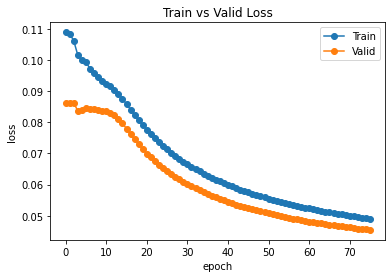

In [111]:
plt.plot(losses_final,'-o')
plt.plot(val_losses_final,'-o')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Loss')
plt.show()

[95.64802613404055, 95.91324796950107, 95.91324796950107, 96.33698512348748, 95.91324796950107, 95.91324796950107, 95.91324796950107, 95.9166114149953, 95.92343729856161, 95.93151123680866, 95.93846068843582, 95.99230908245391, 96.13631524630406, 96.37878473948837, 96.57787569601759, 96.7957887866733, 96.98322044412298, 97.1414983792843, 97.27804367644622, 97.39672007332686, 97.5013522846566, 97.58409887113929, 97.66557219605893, 97.73840885162471, 97.80346253500484, 97.86245942455385, 97.91594773718096, 97.96464740643631, 98.00949773227923, 98.0508426167652, 98.08892259240842, 98.12377649423895, 98.15655906403668, 98.18698855205102, 98.21529587746322, 98.24201394644271, 98.2671584288207, 98.290689294816, 98.31292516579687, 98.33392454653003, 98.3537206080841, 98.3724823079544, 98.39028492689607, 98.40721490501075, 98.42328774716269, 98.43870422744351, 98.45337441160339, 98.46736056846076, 98.48070576300631, 98.49345715044528, 98.50566590542142, 98.5173623122344, 98.52856540798658, 98.

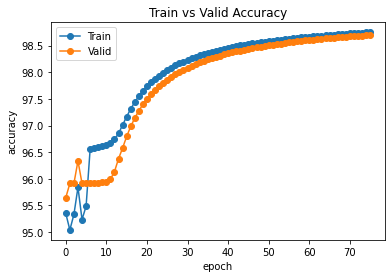

In [110]:
print(valid_accuracy)
print(training_accuracy)
plt.plot(training_accuracy,'-o')
plt.plot(valid_accuracy,'-o')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train','Valid'])
plt.title('Train vs Valid Accuracy')

plt.show()

In [ ]:
# app = FastAPI(title="ML Models as API on Google Colab", description="with FastAPI and ColabCode", version="1.0")
# @app.on_event("startup")
# @app.post("/api", tags=["prediction"])
# def load_model():
#     global model
#     model = pickle.load(open("model_gb.pkl", "rb"))

In [ ]:
# plt.plot(loss,'-o')
# plt.plot(val_losses,'-o')
# plt.xlabel('epoch')
# plt.ylabel('accuracy')
# plt.legend(['Train','Valid'])
# plt.title('Train vs Valid Accuracy')

# plt.show()

In [ ]:
# change the name, for saving multiple files
model_name = 'rnn_1_epoch.net'

checkpoint = {'n_hidden': net.n_hidden,
              'n_layers': net.n_layers,
              'state_dict': net.state_dict()}

with open(model_name, 'wb') as f:
    torch.save(checkpoint, f)

In [ ]:
# Here we have loaded in a model that trained over 1 epoch `rnn_1_epoch.net`
with open('rnn_1_epoch.net', 'rb') as f:
    checkpoint = torch.load(f)
    
loaded = WordSegment(len(CHARS), len(POSTAGS), n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'])
loaded.load_state_dict(checkpoint['state_dict'])

In [ ]:
if torch.cuda.is_available():
   loaded.cuda()

# Inference

In [129]:
# def segment(sample,net):
#     net.eval()
#     #sample ='ខ្ញុំទៅសាលារៀន'
#     sample_chars = list(sample)
#     sample_index = [chars2idx[x] for x in sample_chars ]
#     sample_arr = torch.from_numpy(np.array(sample_index)).unsqueeze(0)
#     sample_encoded = one_hot_encode(sample_arr,len(CHARS))

#     if(train_on_gpu):
#         sample_encoded = sample_encoded.cuda()

#     h = net.init_hidden(1)

#     h = tuple([each.data for each in h])
#     outputs,_ = net(sample_encoded,h)
#     outputs = torch.sigmoid(outputs)
#     if(train_on_gpu):
#         outputs  =outputs.detach().cpu().numpy()
#     else:
#         outputs  =outputs.detach().numpy()
#     print(outputs)
#     # idx = np.argmax(outputs, axis = 1)
#     # print(idx)
#     result = ''
#     t = ''
#     print(len(sample_chars))
#     for i,c in enumerate(sample_chars):
#       print(outputs[i])
#       print(np.where(outputs[i] == max(outputs[i]), 1, 0))
#       print(c)
def segment(sample,net):
    net.eval()
    #sample ='ខ្ញុំទៅសាលារៀន'
    sample_chars = list(sample)
    sample_index = [chars2idx[x] for x in sample_chars ]
    sample_arr = torch.from_numpy(np.array(sample_index)).unsqueeze(0)
    sample_encoded = one_hot_encode(sample_arr,len(CHARS))

    if(train_on_gpu):
        sample_encoded = sample_encoded.cuda()

    h = net.init_hidden(1)

    h = tuple([each.data for each in h])
    outputs,_ = net(sample_encoded,h)
    outputs = torch.sigmoid(outputs)
    print(len(outputs))
    if(train_on_gpu):
        outputs  =outputs.detach().cpu().numpy()
    else:
        outputs  =outputs.detach().numpy()
    idx =(outputs>=0.5).astype(int)
    predicts = one_hot.inverse_transform(idx)
    print(predicts)
    result = ''
    t = ''
    for i, c in enumerate(sample_chars):
        print(len(predicts[i]))
        if (predicts[i][0] !=1):
            # if result =='':
            #     result +=c
                # t = idx2tags[predicts[i][0]]
            if(len(predicts[i])==2):
                result +=t + ' ' +c
                t= idx2tags[predicts[i][1]]
            else:
                result +='_'+ t + ' ' +c
                t = idx2tags[predicts[i][0]]
        else:
            result +=c
    return result+'_'+ t

    # for i,c in enumerate(sample_chars):
    #     if idx[i] != 1:
    #         if result =='':
    #             result +=c
    #             t = idx2tags[idx[i]]
    #         else:
    #             result +='_'+ t + ' ' +c
    #             t = idx2tags[idx[i]]
    #     else:
    #         result +=c
    # return result+'_'+ t

In [125]:
# samples ='អាវថ្មី'
samples = 'ចូរថែសុខភាពរបស់ខ្លួនឱ្យបានល្អត្រូវចេះអាណិតស្រឡាញ់ខ្លួនឱ្យបានច្រើនអាណិតស្រឡាញ់ដល់ក្រុមគ្រួសារគិតគូរដល់ទឹកចិត្តអ្នកដែលអាណិតស្រឡាញ់យើងនិងខ្លាចបាត់បង់យើងព្រោះបញ្ហាទាំងឡាយដែលបានកើតឡើងចំពោះជីវិតយើងហើយនោះទោះបីជាល្អក្តីអាក្រក់ក្តីវាមិនអាចសារត្រលប់ថយក្រោយដូចខ្សែអាត់សំឡេងឬខ្សែវីដេអូបាននោះទេ។'

In [ ]:
#print(np.argmax([[80, -0.36012337, -0.40979862, -0.4940329,  -0.41396353], [2, 3, 4], [10, 20, 30]], axis = 0))
print(POSTAGS)

In [130]:
segment(samples, net)

282
[(2,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,), (1,),

'_ ចូរថែសុខភាពរបស់ខ្លួនឱ្យបានល្អត្រូវចេះអាណិតស្រឡាញ់ខ្លួនឱ្យបានច្រើនអាណិតស្រឡាញ់ដល់ក្រុមគ្រួសារគិតគូរដល់ទឹកចិត្តអ្នកដែលអាណិតស្រឡាញ់យើងនិងខ្លាចបាត់បង់យើងព្រោះបញ្ហាទាំងឡាយដែលបានកើតឡើងចំពោះជីវិតយើងហើយនោះទោះបីជាល្អក្តីអាក្រក់ក្តីវាមិនអាចសារត្រលប់ថយក្រោយដូចខ្សែអាត់សំឡេងឬខ្សែវីដេអូបាននោះទេ។_n'

In [ ]:
segment(samples, loaded)

In [ ]:
print(len(data[0]))

# Accuracy

In [ ]:
# def predict(test_dl, net):
#     net.eval()
#     test_result =[]
#     for x, y in test_dl:
#       x = one_hot_encode(x, len(CHARS))
#       batch_size = x.shape[0]

#       if(train_on_gpu):
#           sample_encoded = x.cuda()

#       h = net.init_hidden(batch_size)

#       h = tuple([each.data for each in h])
#       outputs,_ = net(sample_encoded,h)
#       if(train_on_gpu):
#           outputs  =outputs.detach().cpu().numpy()
#       else:
#           outputs  =outputs.detach().numpy()
      
#       idx = np.argmax(outputs, axis=1)
#       test_result = [idx2tags[idx[i]] for i in idx]
#       print(test_result)
      

In [ ]:
# predict(test_dl, net)

In [ ]:
# def accuracy(samples):
#   pos_count = {pos: {"correct": 0, "corpus": 0} for pos in POSTAGS}
#   for sample in samples:
pos_count = {pos: {"correct": 0, "corpus": 0} for pos in POSTAGS}
for num, sentence_tag in enumerate(tag_clean_all):
  for i, tag in enumerate(sentence_tag):
    tag_index = tags2idx[tag]
    pos_count[idx2tags[tag_index]]["corpus"] += 1
for num, sentence_tag in enumerate(tag_clean_all):
  for i, tag in enumerate(sentence_tag):
    tag_index = tags2idx[tag]
    pos_count[idx2tags[tag_index]]["correct"] += 1
print(pos_count)


In [ ]:
nototal_correct = 0
total_corpus = 0
for pos in pos_count:
  if pos not in ["ns"]:
    correct = pos_count[pos]["correct"]
    corpus = pos_count[pos]["corpus"]
    total_corpus += pos_count[pos]["corpus"]
    total_correct += pos_count[pos]["correct"]
    accuracy = round((correct / corpus)*100, 2)
    print(f"-- {pos}: {accuracy} | correct: {correct}, corpus: {corpus}")

accuracy = round((total_correct / total_corpus)*100, 2)
print(f"AVERAGE ACCURACY: {accuracy}")